In [1]:
import pandas as pd
import pymssql
from datetime import datetime, date 

import numpy as np
from numpy import log
from prophet import Prophet

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from prophet.plot import add_changepoints_to_plot
import itertools

import holidays
import time

import random
from IPython.display import clear_output
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import pickle

/home/aaqil/aaqil_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
def get_data():
    try:
        con = pymssql.connect(user='username',password = 'password'
                 ,host='server',database='db',autocommit = True)
    except Exception as e:
        print('unable to connnect',e)
    cur=con.cursor()
    
    query="""
            SELECT CONVERT(date, CP.DATE_ENTRY) as Date, COUNT(DISTINCT C.CLAIM_NO) as Claims,
        SUM(CP.AMOUNT_PAID)'PAYMENTS'
        FROM PATIENT AS P
        JOIN CLAIMS AS C ON P.PATIENT_ACCOUNT=C.PATIENT_ACCOUNT

AND ISNULL(C.DELETED,0)=0
        AND ISNULL(P.DELETED,0)=0
        JOIN CLAIM_PAYMENTS AS CP ON C.CLAIM_NO=CP.CLAIM_NO
        AND ISNULL(CP.DELETED,0)=0
        JOIN PRACTICES AS PR ON PR.PRACTICE_CODE=P.PRACTICE_CODE
        AND PR.IS_ACTIVE=1 AND ISNULL(PR.IS_TEST_PRACTICE,0)=0
        AND ISNULL(PR.EXCLUDE_FROM_BILLING_REPORTS,0) = 0
        AND PR.EMR_NAME NOT IN ('CHARTS PRO','PM STANDALONE','TESTINGPRACTICE')
        AND PR.PRACTICE_CODE NOT LIKE '9090%' AND PR.PRAC_NAME NOT LIKE '%TEST%'
        WHERE CONVERT(date, CP.DATE_ENTRY) BETWEEN  CONVERT(date, '01-01-2019')
        AND CONVERT(date, '10-20-2022')
        GROUP BY CONVERT(date, CP.DATE_ENTRY)
        ORDER BY CONVERT(date, CP.DATE_ENTRY) ASC
            """
     
    try:
        cur.execute(query)
        df=pd.DataFrame(cur.fetchall(),columns=[x[0] for x in cur.description])
        cur.close
        con.close
        return df
    except Exception as e:
        print('error in query',e)
        con.close()

In [3]:
df=get_data()

In [4]:
data=df.copy
df.columns
df.shape

(1389, 3)

In [5]:
df.head()

,Date,Claims,PAYMENTS
0,2019-01-01,15589,696717.6800
1,2019-01-02,25068,1133132.8630
2,2019-01-03,30796,1560087.9600
3,2019-01-04,32438,1605829.1200
4,2019-01-05,9597,429901.3300


In [6]:
df['Date']=pd.to_datetime(df['Date'])

In [7]:
claim_data=df[['Date','PAYMENTS']]

In [8]:
claim_data.PAYMENTS.mean()

1242710.022499064

In [9]:
# print(claim_data[claim_data['PAYMENTS']<0].replace(1560087.9600))
y=claim_data.PAYMENTS.mean()
print(type(y))
claim_data.PAYMENTS=claim_data.PAYMENTS.apply(lambda x: y if x<0 else x)
claim_data.PAYMENTS=claim_data.PAYMENTS.apply(lambda x: y if x>3000000 else x)

<class 'numpy.float64'>


In [10]:
# claim_data.PAYMENTS.max()

In [11]:
claim_data.PAYMENTS = claim_data.PAYMENTS.apply(int)

In [12]:
# df[['CHARGE_SUM']].apply(int)

In [13]:
claim_data.head()

,Date,PAYMENTS
0,2019-01-01,696717
1,2019-01-02,1133132
2,2019-01-03,1560087
3,2019-01-04,1605829
4,2019-01-05,429901


In [14]:
claim_data = claim_data.rename(columns={'Date': 'ds','PAYMENTS': 'y'})

In [15]:
claim_data['ds'] = pd.DatetimeIndex(claim_data['ds'])

In [16]:
claim_data.set_index('ds',inplace=True)

In [17]:
train=claim_data.loc[:'09-30-2022']
test=claim_data.loc['10-01-2022':]

In [18]:
train.reset_index(inplace=True)
train.head(10)

,ds,y
0,2019-01-01,696717
1,2019-01-02,1133132
2,2019-01-03,1560087
3,2019-01-04,1605829
4,2019-01-05,429901
5,2019-01-06,134390
6,2019-01-07,1054115
7,2019-01-08,922077
8,2019-01-09,1290293
9,2019-01-10,1195388


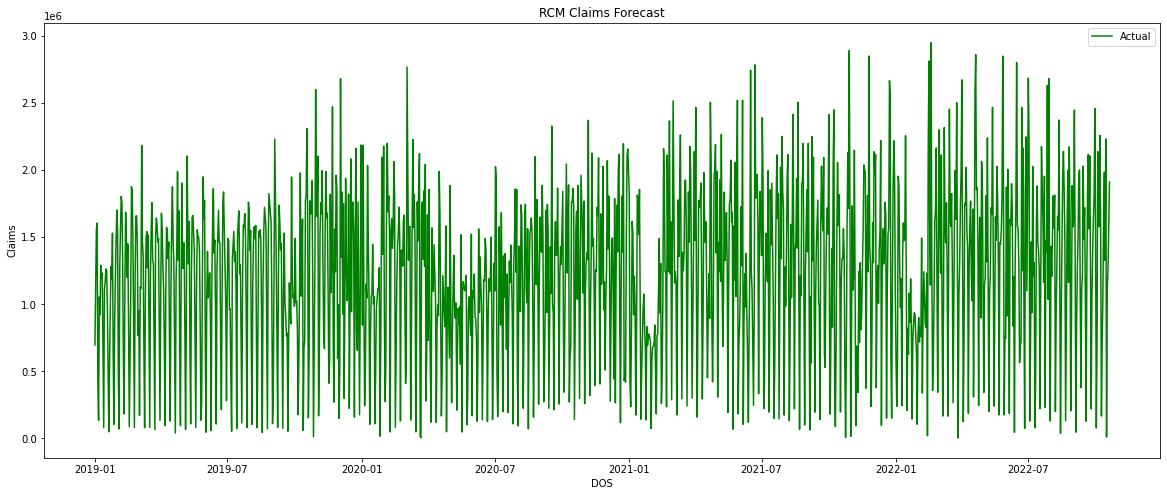

In [19]:
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(claim_data
         ,color='g', label='Actual')
plt.xlabel("DOS")
plt.ylabel("Claims")
plt.title("RCM Claims Forecast")
plt.legend(loc='upper right')
plt.show()

In [20]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2021,2022]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [21]:
test_fc=test.reset_index()
test_fc.head()

,ds,y
0,2022-10-01,1507945
1,2022-10-02,78613
2,2022-10-03,712699
3,2022-10-04,2138273
4,2022-10-05,1652289


In [22]:
train_fc=train.set_index('ds')#.loc['01-01-2020':]
train_fc=train_fc.reset_index()
train_fc.head()

,ds,y
0,2019-01-01,696717
1,2019-01-02,1133132
2,2019-01-03,1560087
3,2019-01-04,1605829
4,2019-01-05,429901


### Hyperparameter Tuning

In [23]:
my_model = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,)

In [24]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[10,15,20],
              'n_changepoints' : [25,50,75,100,125]
              }
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [25]:
future_dates=pd.DataFrame(test_fc['ds'])
future_dates
model_parameters = pd.DataFrame(columns = ['mape','me','rmse','Parameters'])
cnt=1
for p in grid:
    clear_output(wait=True)
    print('Running at: ',cnt)
    cnt+=1
    test = pd.DataFrame()
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         holidays=holiday, 
#                          daily_seasonality=True,
#                          yearly_seasonality=True,
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(train)
    train_forecast = train_model.predict(future_dates)
    fc=train_forecast[['ds','yhat']]
    me = me = np.mean(fc.yhat - test_fc.y)
    mape=np.mean(np.abs(fc.yhat - test_fc.y)/np.abs(test_fc.y)) 
    rmse=rmse = np.mean((fc.yhat - test_fc.y)**2)**.5
    model_parameters = model_parameters.append({'mape':mape,'me':me,'rmse':rmse,'Parameters':p},ignore_index=True)
    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


Running at:  150


INFO:cmdstanpy:finish chain 1


In [26]:
md=model_parameters.copy()
md['me']=abs(md['me'])
md.sort_values(by=['rmse'],ascending=True).iloc[0]['Parameters']


{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 15,
 'n_changepoints': 100,
 'seasonality_mode': 'multiplicative'}

In [27]:
#best rmse vale
{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 20,
 'n_changepoints': 100,
 'seasonality_mode': 'multiplicative'}

#best mape value
{'changepoint_prior_scale': 0.5,
 'holidays_prior_scale': 10,
 'n_changepoints': 50,
 'seasonality_mode': 'additive'}

my_model1 = Prophet(changepoint_prior_scale = 0.1,
                     holidays_prior_scale = 20,
                     n_changepoints = 125,
                     seasonality_mode = 'multiplicative',
                     weekly_seasonality=True,
#                      daily_seasonality=True,
#                      yearly_seasonality=True,
                     holidays=holiday,
                     interval_width=0.95)

In [28]:
my_model1.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [29]:
filename = 'RCM_Prophet_Overall_Payments_Charges.sav'
pickle.dump(my_model1, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))

date_range=pd.date_range(start = '09-01-2022', end = '09-20-2022')
future_dates=pd.DataFrame(date_range,columns=['ds'])


forecast_outsample = loaded_model.predict(future_dates)
forecast_outsample[['ds', 'yhat']].tail()

,ds,yhat
15,2022-09-16,1816947.58382
16,2022-09-17,1285047.99467
17,2022-09-18,179441.48520
18,2022-09-19,1111090.72848
19,2022-09-20,1632663.78098


In [30]:
test=claim_data.loc['09-01-2022':'10-20-2022']

future_dates=pd.DataFrame(test.reset_index()['ds'])
future_dates

date_range=pd.date_range(start = '10-01-2022', end = '03-15-2023')
fd=pd.DataFrame(date_range,columns=['ds'])
test.tail()

,y
ds,
2022-10-16,10330
2022-10-17,1126474
2022-10-18,1258656
2022-10-19,1576801
2022-10-20,1912288


In [31]:
forecast_outsample = my_model1.predict(fd)
forecast_outsample[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(50)


,ds,yhat,yhat_lower,yhat_upper
0,2022-10-01,1278840.44106,549360.45638,2011525.15297
1,2022-10-02,182913.49280,-551084.99108,872707.10223
2,2022-10-03,1130064.81311,408244.10093,1817677.06662
3,2022-10-04,1666217.18410,949536.04556,2426793.38918
4,2022-10-05,1755386.57577,1011155.81668,2470000.10934
5,2022-10-06,1722065.60877,961256.39007,2470323.36364
6,2022-10-07,1858541.07028,1073306.98780,2555097.86291
7,2022-10-08,1340026.51405,605998.24459,2089531.91714
8,2022-10-09,245157.38048,-496895.72503,1002229.27705
9,2022-10-10,931847.88332,187945.94377,1650139.82027


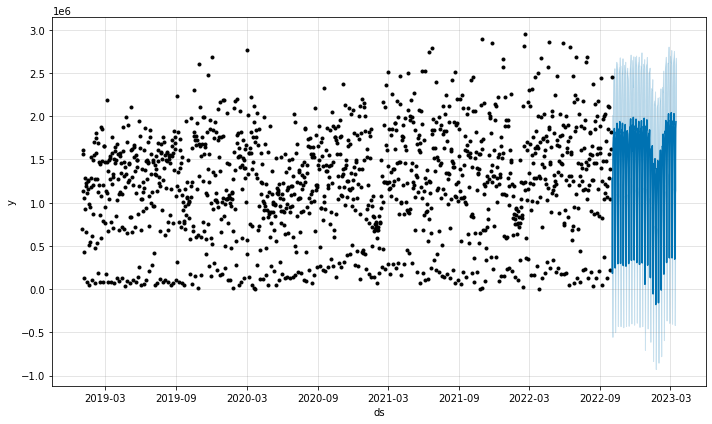

In [32]:
fig=my_model1.plot(forecast_outsample, uncertainty=True)

In [33]:
fc=forecast_outsample[['ds','yhat']]
fc.set_index('ds',inplace=True)
fc.head()

,yhat
ds,
2022-10-01,1278840.44106
2022-10-02,182913.49280
2022-10-03,1130064.81311
2022-10-04,1666217.18410
2022-10-05,1755386.57577


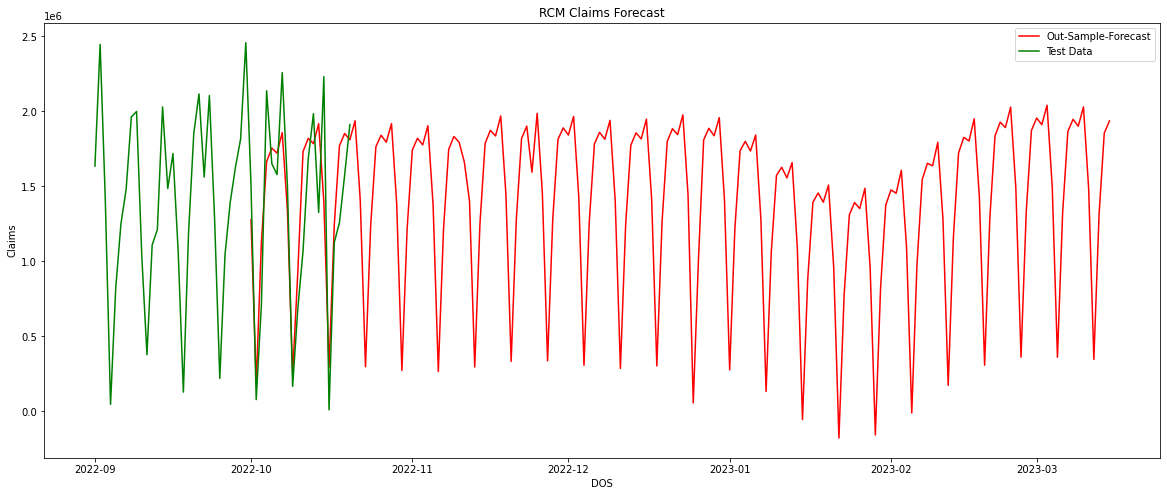

In [34]:
plt.rcParams["figure.figsize"] = (20,8)
#plt.plot(train.set_index('ds'),color='y', label='Train Data')
#plt.plot(tc,color='b', label='In-Sample-Forecast')
plt.plot(fc,color='r', label='Out-Sample-Forecast')
plt.plot(test,color='g', label='Test Data')
plt.xlabel("DOS")
plt.ylabel("Claims")
plt.title("RCM Claims Forecast")
plt.legend(loc='upper right')
plt.show()

In [35]:
# print('ME Out Sample Forecast: ',np.mean(fc.values-test.values))

# print('RMSE Out Sample Forecast: ',np.mean((fc.yhat - test.y)**2)**.5 )

# print('MAPE: ',np.mean(np.abs(fc.yhat - test.y)/np.abs(test.y)))

In [36]:
d=pd.merge(
    forecast_outsample[['ds', 'yhat']],
    test.reset_index(),
    how="left",
    on=['ds'],
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)
d['diff']=abs(d['yhat']-d['y'])
#d.to_csv('prophet.csv')
d.head(1000)

,ds,yhat,y,diff
0,2022-10-01,1278840.44106,1507945.00000,229104.55894
1,2022-10-02,182913.49280,78613.00000,104300.49280
2,2022-10-03,1130064.81311,712699.00000,417365.81311
3,2022-10-04,1666217.18410,2138273.00000,472055.81590
4,2022-10-05,1755386.57577,1652289.00000,103097.57577
...,...,...,...,...
161,2023-03-11,1485000.55174,NaN,NaN
162,2023-03-12,346945.55490,NaN,NaN
163,2023-03-13,1313352.60683,NaN,NaN
164,2023-03-14,1855726.57222,NaN,NaN


In [37]:
predicted=d['yhat'].sum()
original=d['y'].sum()

print(predicted,original)


(original/predicted)*100
(predicted/original)*100

231899454.95441306 26466806.0


876.1898014985755

In [38]:
original-predicted

-205432648.95441306

In [39]:
def DUMP_DATA(d,forecast_section,pracice_code):
    data_to_dump=d[['yhat','ds']]
    data_to_dump['PRACTICE_CODE']=pracice_code
    data_to_dump['FORECAST_TYPE']=forecast_section
    data_to_dump.rename(columns={"yhat": "FORECASTED_VALUE", "ds": "FORECAST_DATE"},inplace=True)

    con = pymssql.connect(user='mtbcweb',password = 'mtbcweb@mtbc'
                         ,host='172.16.0.168',database='AmazingDb',autocommit = True)
    cur=con.cursor()
    for i, row in data_to_dump.iterrows():
        query="""
            insert into DS_RCM_Forecasting(practice_code,forecasted_value,Forecast_date,Forecast_section)
        values(%s,%s,%s,%s)
            """
        cur.execute(query, (row['PRACTICE_CODE'],row['FORECASTED_VALUE'],row['FORECAST_DATE'],row['FORECAST_TYPE']))
    print('Data Inserted')
    con.close()

In [40]:
DUMP_DATA(d,'Overall_Payments_Charges', 0)

Data Inserted
